In [265]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [266]:
# put current date and time in filename
INPUT_GLOB = "out/gst-client*"
INPUT_ORCHESTRATOR = "out/gst-orchestrator.out"

# get date of newest file in output directory
newest_t = datetime.datetime.fromtimestamp(os.path.getctime(max(glob.iglob(INPUT_GLOB), key=os.path.getctime))).strftime('%Y-%m-%d-%H-%M-%S')

OUTPUT_FILE = f"output/results-{newest_t}.csv"
OUTPUT_ORCHESTRATOR = f"output/orchestrator-{newest_t}.csv"

In [267]:
print(f"Reading from {INPUT_GLOB} and writing to {OUTPUT_FILE}")

Reading from out/gst-client* and writing to output/results-2024-07-09-14-27-12.csv


In [268]:
client_logs = []

for filename in glob.glob(INPUT_GLOB):
    print(f"Processing {filename}")
    client_no = filename.split("client-")[1].split(".out")[0]
    with open(filename, "r") as log_f:
        for line in log_f:
            if "request_info" not in line:
                continue

            try:
                # extract the request info
                request_info = line.split("request_info: ")[1].strip().split(",")

                cache_hit = request_info[2]

                parts = line.split(" ")
                timestamp = parts[0] + " " + parts[1]

                client_logs.append((timestamp, client_no, request_info[0], request_info[1], cache_hit, request_info[3], request_info[4]))
            except Exception:
                pass

df = pd.DataFrame(client_logs, columns=["timestamp", "client", "key", "time", "cache_hit", "len", "host"])
df["len"] = df["len"].astype(int)
df["time"] = df["time"].astype(float)
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y/%m/%d %H:%M:%S.%f")

# df = pd.read_csv(OUTPUT_FILE)
# df.to_csv(OUTPUT_FILE, index=False)

Processing out/gst-client-centralia.out
Processing out/gst-client-everett.out
Processing out/gst-client-snoqualmie.out
Processing out/gst-client-shaniko.out
Processing out/gst-client-darby.out
Processing out/gst-client-may.out
Processing out/gst-client-baker.out
Processing out/gst-client-brownsville.out
Processing out/gst-client-medford.out
Processing out/gst-client-packwood.out
Processing out/gst-client-cobalt.out
Processing out/gst-client-ritzville.out
Processing out/gst-client-charlo.out
Processing out/gst-client-odessa.out
Processing out/gst-client-twinfalls.out
Processing out/gst-client-wisdom.out
Processing out/gst-client-kalispell.out
Processing out/gst-client-burns.out
Processing out/gst-client-prescott.out
Processing out/gst-client-yakima.out
Processing out/gst-client-lagrande.out
Processing out/gst-client-seneca.out
Processing out/gst-client-greatfalls.out
Processing out/gst-client-maupin.out
Processing out/gst-client-corvallis.out
Processing out/gst-client-mccall.out
Process

In [269]:
# now read the orchestrator input
orchestrator_logs = []
distance_logs = []
deployed_sats = 0

with open(INPUT_ORCHESTRATOR, "r") as log_f:
    for line in log_f:
        if "curr_sat_distance" in line:
            parts = line.split(":")
            timestamp = parts[0] + ":" + parts[1] + ":" + parts[2]

            interesting_stuff = parts[-1].strip().split(",")
            sat = interesting_stuff[0]
            distance = float(interesting_stuff[-1])
            client = interesting_stuff[1].split("'")[1][len("client-"):]
            distance_logs.append((timestamp, sat, client, distance))
            continue

        if "deploy_start_info" not in line and "deploy_complete_info" not in line and "undeploy_start_info" not in line and "undeploy_complete_info" not in line:
            continue

        parts = line.split(":")

        timestamp = parts[0] + ":" + parts[1] + ":" + parts[2]

        log_type = {
            "deploy_start_info": "deploy_start",
            "deploy_complete_info": "deploy_complete",
            "undeploy_start_info": "undeploy_start",
            "undeploy_complete_info": "undeploy_complete"
        }[parts[5].strip()]

        data = parts[6].strip().split(" ")
        num_sats = int(data[0])
        if num_sats == 0:
            continue
        sats = data[1].split(",")

        if log_type == "deploy_start":
            deployed_sats += num_sats

        if log_type == "undeploy_complete":
            deployed_sats -= num_sats

        orchestrator_logs.append((timestamp, log_type, num_sats, deployed_sats))

orch_df = pd.DataFrame(orchestrator_logs, columns=["timestamp", "log_type", "num_sats", "deployed_sats"])
orch_df["timestamp"] = pd.to_datetime(orch_df["timestamp"], format="%Y-%m-%d %H:%M:%S,%f")
orch_df.to_csv(OUTPUT_ORCHESTRATOR, index=False)

distance_df = pd.DataFrame(distance_logs, columns=["timestamp", "sat", "client", "distance"])
distance_df["timestamp"] = pd.to_datetime(distance_df["timestamp"], format="%Y-%m-%d %H:%M:%S,%f")

orch_df.head()

,timestamp,log_type,num_sats,deployed_sats
0,2024-07-09 12:03:05.461,deploy_start,6,6
1,2024-07-09 12:03:21.448,deploy_complete,6,6
2,2024-07-09 12:03:51.955,deploy_start,1,7
3,2024-07-09 12:04:06.557,deploy_complete,1,7
4,2024-07-09 12:04:14.277,deploy_start,1,8


In [270]:
distance_df.head()

,timestamp,sat,client,distance
0,2024-07-09 12:03:22.239,1-29,aberdeen,2004.0
1,2024-07-09 12:03:22.245,1-51,lagrande,2367.0
2,2024-07-09 12:03:22.250,1-51,roslyn,1970.0
3,2024-07-09 12:03:22.254,1-73,pullman,2114.0
4,2024-07-09 12:03:22.255,1-73,mccall,3921.0


In [271]:
# convert time to something useful
df["time_ms"] = df["time"] * 1000

In [272]:
df.head()

,timestamp,client,key,time,cache_hit,len,host,time_ms
0,2024-07-09 12:03:22.027660,centralia,/wikipedia/commons/1/12/BSicon_ABZgr.svg0_199,0.093932,False,531,29.1.celestial:8000/cdn,93.932
1,2024-07-09 12:03:22.031664,centralia,/wikipedia/commons/6/66/Wikidata-logo-en.svg0_199,0.098857,False,162,29.1.celestial:8000/cdn,98.857
2,2024-07-09 12:03:24.103385,centralia,/wikipedia/commons/3/31/Rome-Seleucia-Parthia_...,0.150823,False,661162,29.1.celestial:8000/cdn,150.823
3,2024-07-09 12:03:28.970910,centralia,/wikipedia/commons/6/64/Aidablennius_sphynx.jp...,0.058763,False,20840,29.1.celestial:8000/cdn,58.763
4,2024-07-09 12:03:33.963693,centralia,/wikipedia/commons/a/a4/Socrates_Louvre.jpg200...,0.043875,False,47701,29.1.celestial:8000/cdn,43.875


In [273]:
# merge the distances to the requests
df = pd.merge_asof(df.sort_values("timestamp"), distance_df.sort_values("timestamp"), on="timestamp", by="client")
df = df.dropna()
df.head()

,timestamp,client,key,time,cache_hit,len,host,time_ms,sat,distance
54,2024-07-09 12:03:22.268665,malden,/wikipedia/commons/5/5d/Flag_of_Philadelphia2C...,0.123949,False,2087,51.1.celestial:8000/cdn,123.949,1-51,2042.0
55,2024-07-09 12:03:22.281320,baker,/wikipedia/commons/d/db/Melanie_Thornton_at_Le...,0.037623,False,3604,138.1.celestial:8000/cdn,37.623,1-138,2477.0
56,2024-07-09 12:03:22.284139,salmon,/wikipedia/commons/4/49/ArrowLeftNavbox.svg0_199,0.103269,False,374,73.1.celestial:8000/cdn,103.269,1-73,2372.0
57,2024-07-09 12:03:22.290429,may,/wikipedia/commons/c/cf/Ted_Bundy_Volkswagen.j...,0.104603,False,30788,160.1.celestial:8000/cdn,104.603,1-160,2378.0
58,2024-07-09 12:03:22.302356,wisdom,/wikipedia/commons/e/ea/Nakayama-Festa20100627...,0.052678,False,3757,73.1.celestial:8000/cdn,52.678,1-73,2283.0


In [274]:
df.to_csv(OUTPUT_FILE, index=False)

<Axes: xlabel='time_ms', ylabel='Proportion'>

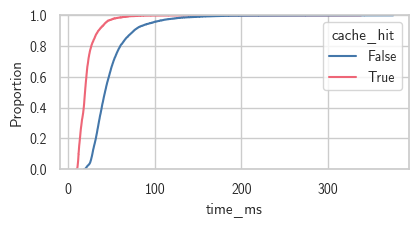

In [275]:
sns.ecdfplot(data=df, x='time_ms', hue='cache_hit')

[(0.0, 500.0)]

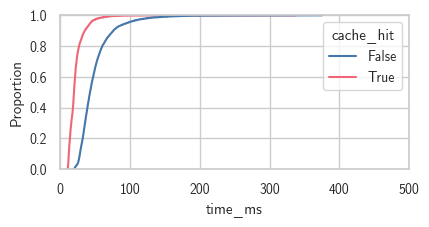

In [276]:
g = sns.ecdfplot(data=df, x='time_ms', hue='cache_hit')
g.set(xlim=(0, 500))

In [277]:
df.groupby('cache_hit')['time_ms'].count()

cache_hit
False    9431
True     4849
Name: time_ms, dtype: int64

In [278]:
df.groupby(["client", 'cache_hit'])['time_ms'].count()

client    cache_hit
aberdeen  False        181
          True         105
baker     False        204
          True          82
bannack   False        177
                      ... 
wisdom    True         102
yachats   False        190
          True          97
yakima    False        188
          True          98
Name: time_ms, Length: 100, dtype: int64

In [279]:
# max for each hit type
df.groupby('cache_hit')['time_ms'].min()

cache_hit
False    18.337
True      9.414
Name: time_ms, dtype: float64

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_73769/1804022635.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, '51.1.celestial:8000/cdn'),
 Text(1, 0, '138.1.celestial:8000/cdn'),
 Text(2, 0, '73.1.celestial:8000/cdn'),
 Text(3, 0, '160.1.celestial:8000/cdn'),
 Text(4, 0, '116.1.celestial:8000/cdn'),
 Text(5, 0, '29.1.celestial:8000/cdn'),
 Text(6, 0, '94.1.celestial:8000/cdn'),
 Text(7, 0, '7.1.celestial:8000/cdn'),
 Text(8, 0, '72.1.celestial:8000/cdn'),
 Text(9, 0, '159.1.celestial:8000/cdn'),
 Text(10, 0, '203.1.celestial:8000/cdn'),
 Text(11, 0, '50.1.celestial:8000/cdn'),
 Text(12, 0, '137.1.celestial:8000/cdn'),
 Text(13, 0, '181.1.celestial:8000/cdn'),
 Text(14, 0, '115.1.celestial:8000/cdn'),
 Text(15, 0, '28.1.celestial:8000/cdn'),
 Text(16, 0, '6.1.celestial:8000/cdn'),
 Text(17, 0, '93.1.celestial:8000/cdn'),
 Text(18, 0, '158.1.celestial:8000/cdn'),
 Text(19, 0, '71.1.celestial:8000/cdn'),
 Text(20, 0, '180.1.celestial:8000/cdn'),
 Text(21, 0, '136.1.celestial:8000/cdn'),
 Text(22, 0, '49.1.celestial:8000/cdn'),
 Text(23, 0, '114.1.celestial:8000/cdn'),
 Text(24, 0, '27

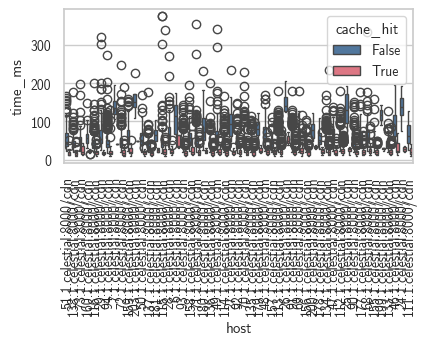

In [280]:
g = sns.boxplot(data=df, y='time_ms', x='host', hue='cache_hit')
# make x axis labels vertical
g.set_xticklabels(g.get_xticklabels(), rotation=90)

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_73769/186471702.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'malden'),
 Text(1, 0, 'baker'),
 Text(2, 0, 'salmon'),
 Text(3, 0, 'may'),
 Text(4, 0, 'wisdom'),
 Text(5, 0, 'seneca'),
 Text(6, 0, 'odessa'),
 Text(7, 0, 'kalispell'),
 Text(8, 0, 'shaniko'),
 Text(9, 0, 'yachats'),
 Text(10, 0, 'ritzville'),
 Text(11, 0, 'bend'),
 Text(12, 0, 'bozeman'),
 Text(13, 0, 'bannack'),
 Text(14, 0, 'kalaloch'),
 Text(15, 0, 'brownsville'),
 Text(16, 0, 'pocatello'),
 Text(17, 0, 'charlo'),
 Text(18, 0, 'corvallis'),
 Text(19, 0, 'prescott'),
 Text(20, 0, 'baringoo'),
 Text(21, 0, 'everett'),
 Text(22, 0, 'tillamook'),
 Text(23, 0, 'quincy'),
 Text(24, 0, 'aberdeen'),
 Text(25, 0, 'roslyn'),
 Text(26, 0, 'lagrande'),
 Text(27, 0, 'pullman'),
 Text(28, 0, 'mccall'),
 Text(29, 0, 'boardman'),
 Text(30, 0, 'pollock'),
 Text(31, 0, 'spokane'),
 Text(32, 0, 'kimberly'),
 Text(33, 0, 'snoqualmie'),
 Text(34, 0, 'centralia'),
 Text(35, 0, 'kennewick'),
 Text(36, 0, 'clarkia'),
 Text(37, 0, 'darby'),
 Text(38, 0, 'burns'),
 Text(39, 0, 'greatfalls'),
 

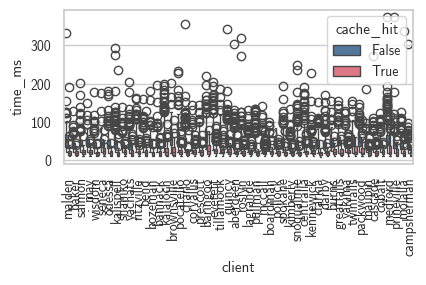

In [281]:
g = sns.boxplot(data=df, y='time_ms', x='client', hue='cache_hit')
# make x axis labels vertical
g.set_xticklabels(g.get_xticklabels(), rotation=90)

83.01304999999996


/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_73769/3525717891.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'baker'),
 Text(1, 0, 'wisdom'),
 Text(2, 0, 'odessa'),
 Text(3, 0, 'kalispell'),
 Text(4, 0, 'shaniko'),
 Text(5, 0, 'yachats'),
 Text(6, 0, 'ritzville'),
 Text(7, 0, 'bend'),
 Text(8, 0, 'bozeman'),
 Text(9, 0, 'bannack'),
 Text(10, 0, 'brownsville'),
 Text(11, 0, 'pocatello'),
 Text(12, 0, 'charlo'),
 Text(13, 0, 'corvallis'),
 Text(14, 0, 'aberdeen'),
 Text(15, 0, 'roslyn'),
 Text(16, 0, 'lagrande'),
 Text(17, 0, 'pullman'),
 Text(18, 0, 'mccall'),
 Text(19, 0, 'boardman'),
 Text(20, 0, 'pollock'),
 Text(21, 0, 'spokane'),
 Text(22, 0, 'kimberly'),
 Text(23, 0, 'snoqualmie'),
 Text(24, 0, 'kennewick'),
 Text(25, 0, 'clarkia'),
 Text(26, 0, 'darby'),
 Text(27, 0, 'malden'),
 Text(28, 0, 'seneca'),
 Text(29, 0, 'burns'),
 Text(30, 0, 'greatfalls'),
 Text(31, 0, 'salmon'),
 Text(32, 0, 'may'),
 Text(33, 0, 'tillamook'),
 Text(34, 0, 'prescott'),
 Text(35, 0, 'baringoo'),
 Text(36, 0, 'quincy'),
 Text(37, 0, 'yakima'),
 Text(38, 0, 'twinfalls'),
 Text(39, 0, 'packwood'),
 T

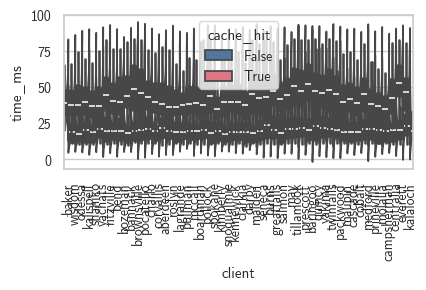

In [282]:
cut_off_df = df[df["cache_hit"] != "Fail"]

cut_off_99 = cut_off_df['time_ms'].quantile(0.95)
print(cut_off_99)

cut_off_df = cut_off_df[cut_off_df['time_ms'] < cut_off_99]

g = sns.violinplot(data=cut_off_df, y='time_ms', x='client', hue='cache_hit', split=True)
# make x axis labels vertical
g.set_xticklabels(g.get_xticklabels(), rotation=90)

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_73769/2210836645.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'aberdeen'),
 Text(1, 0, 'baker'),
 Text(2, 0, 'bannack'),
 Text(3, 0, 'baringoo'),
 Text(4, 0, 'bend'),
 Text(5, 0, 'boardman'),
 Text(6, 0, 'bozeman'),
 Text(7, 0, 'brownsville'),
 Text(8, 0, 'burns'),
 Text(9, 0, 'campsherman'),
 Text(10, 0, 'cascade'),
 Text(11, 0, 'centralia'),
 Text(12, 0, 'charlo'),
 Text(13, 0, 'clarkia'),
 Text(14, 0, 'cobalt'),
 Text(15, 0, 'corvallis'),
 Text(16, 0, 'darby'),
 Text(17, 0, 'everett'),
 Text(18, 0, 'greatfalls'),
 Text(19, 0, 'kalaloch'),
 Text(20, 0, 'kalispell'),
 Text(21, 0, 'kennewick'),
 Text(22, 0, 'kimberly'),
 Text(23, 0, 'lagrande'),
 Text(24, 0, 'malden'),
 Text(25, 0, 'maupin'),
 Text(26, 0, 'may'),
 Text(27, 0, 'mccall'),
 Text(28, 0, 'medford'),
 Text(29, 0, 'molalla'),
 Text(30, 0, 'odessa'),
 Text(31, 0, 'packwood'),
 Text(32, 0, 'pocatello'),
 Text(33, 0, 'pollock'),
 Text(34, 0, 'prescott'),
 Text(35, 0, 'prineville'),
 Text(36, 0, 'pullman'),
 Text(37, 0, 'quincy'),
 Text(38, 0, 'ritzville'),
 Text(39, 0, 'roslyn'

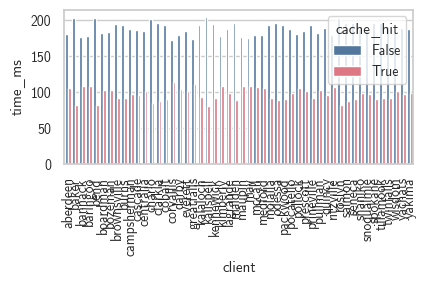

In [283]:
count_df = df[df["cache_hit"] != "Fail"].groupby(["client", "cache_hit"])["time_ms"].count().reset_index()

g = sns.barplot(data=count_df, x='client', y='time_ms', hue='cache_hit')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [284]:
# how many cache hits and misses are there?
print(df['cache_hit'].value_counts()/len(df))

cache_hit
False    0.660434
True     0.339566
Name: count, dtype: float64


In [285]:
# how many ops per client?
print(df['client'].value_counts())

client
corvallis      287
yachats        287
tillamook      287
pocatello      287
brownsville    287
kalaloch       287
bozeman        287
baringoo       287
everett        287
mccall         286
boardman       286
baker          286
pollock        286
aberdeen       286
spokane        286
kimberly       286
centralia      286
quincy         286
kennewick      286
lagrande       286
yakima         286
prescott       286
charlo         286
bannack        286
bend           286
ritzville      286
shaniko        286
kalispell      286
odessa         286
seneca         286
wisdom         286
prineville     286
greatfalls     285
medford        285
maupin         285
molalla        285
malden         285
roslyn         285
snoqualmie     285
pullman        285
may            285
salmon         285
campsherman    285
burns          284
darby          284
twinfalls      284
clarkia        283
packwood       283
cascade        283
cobalt         283
Name: count, dtype: int64


In [286]:
tmp = []

for filename in glob.glob("out/1-*.out"):
    print(f"Processing {filename}")
    client_no = filename.split("1-")[1].split(".out")[0]
    with open(filename, "r") as log_f:
        for line in log_f:
            if "Origin took" not in line:
                continue

            # extract the request info
            request_info = line.split("Origin took")[1].strip().split(" ")[0]

            tmp.append((client_no, float(request_info)))

client_df = pd.DataFrame(tmp, columns=["client", "time"])

Processing out/1-159.out
Processing out/1-68.out
Processing out/1-69.out
Processing out/1-158.out
Processing out/1-199.out
Processing out/1-94.out
Processing out/1-204.out
Processing out/1-95.out
Processing out/1-198.out
Processing out/1-177.out
Processing out/1-46.out
Processing out/1-91.out
Processing out/1-201.out
Processing out/1-200.out
Processing out/1-90.out
Processing out/1-47.out
Processing out/1-176.out
Processing out/1-160.out
Processing out/1-45.out
Processing out/1-51.out
Processing out/1-92.out
Processing out/1-202.out
Processing out/1-203.out
Processing out/1-93.out
Processing out/1-50.out
Processing out/1-112.out
Processing out/1-8.out
Processing out/1-264.out
Processing out/1-265.out
Processing out/1-113.out
Processing out/1-111.out
Processing out/1-267.out
Processing out/1-266.out
Processing out/1-110.out
Processing out/1-138.out
Processing out/1-114.out
Processing out/1-25.out
Processing out/1-24.out
Processing out/1-115.out
Processing out/1-117.out
Processing out/1-

In [287]:
client_df.head()

,client,time


/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_73769/1885366874.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  g.set(yscale='log')


[None]

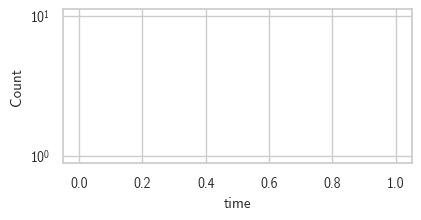

In [288]:
g = sns.histplot(data=client_df, x='time')
g.set(yscale='log')

[(0.0, 3.0)]

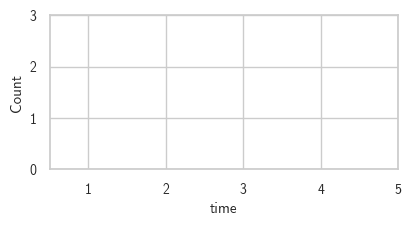

In [289]:
g = sns.histplot(data=client_df, x='time')
g.set(xlim=(0.5, 5))
g.set(ylim=(0, 3))

In [290]:
# let's look at the origin server
tmp = []
with open("out/gst-origin.out", "r") as f:
    for line in f:
        if "Served" not in line:
            continue

        tstamp = line.split(" ")[2][1:-1]
        name = line.split(" ")[4]
        length = line.split(" ")[6]

        tmp.append((name, int(tstamp), float(length)))

orig_df = pd.DataFrame(tmp, columns=["name", "time", "length"])
orig_df["time"] = orig_df["time"] - orig_df["time"].min()

<Axes: xlabel='time', ylabel='length'>

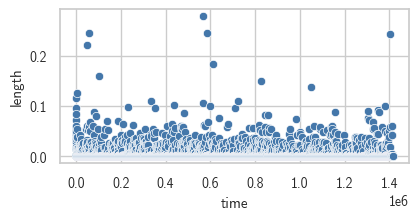

In [291]:
sns.scatterplot(data=orig_df, x='time', y='length')

                        timestamp  deployed_sats     time
0      2024-07-09 12:03:22.268665              6     0.00
1      2024-07-09 12:03:22.278665              6     0.01
2      2024-07-09 12:03:22.288665              6     0.02
3      2024-07-09 12:03:22.298665              6     0.03
4      2024-07-09 12:03:22.308665              6     0.04
...                           ...            ...      ...
142752 2024-07-09 12:27:09.788665              5  1427.52
142753 2024-07-09 12:27:09.798665              5  1427.53
142754 2024-07-09 12:27:09.808665              5  1427.54
142755 2024-07-09 12:27:09.818665              5  1427.55
142756 2024-07-09 12:27:09.828665              5  1427.56

[142757 rows x 3 columns]


webf NOT subset; don't know how to subset; dropped


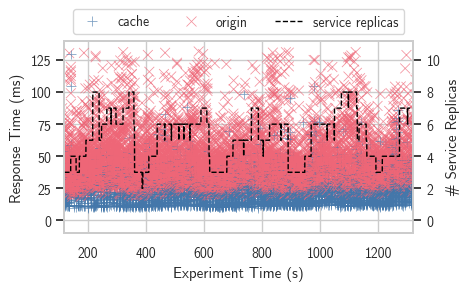

In [295]:
results_df = df[df["cache_hit"] != "Fail"]
# results_df = df

# only keep the middle 20 minutes of the data
# results_df = results_df[(results_df["timestamp"] >= results_df["timestamp"].min() + pd.Timedelta(minutes=2)) & (results_df["timestamp"] <= results_df["timestamp"].min() + pd.Timedelta(minutes=22))]

put_95 = results_df["time_ms"].quantile(0.99)
distance_99 = results_df["distance"].quantile(0.95)

results_df = results_df[results_df["time_ms"] < put_95]
results_df = results_df[results_df["distance"] < distance_99]

results_df["time"] = (results_df["timestamp"].astype(int) - results_df["timestamp"].astype(int).min()) / 1e9

# cmap = sns.color_palette("viridis", as_cmap=True)

fig, ax = plt.subplots(figsize=(4.5, 2.5))

# sns.scatterplot(data=results_df, x='time', y='time_ms', ax=ax, alpha=0.7, markers=['x', "+"], style="cache_hit", hue='len', s=50, palette=cmap)
sns.scatterplot(data=results_df, x='time', y='time_ms', ax=ax, alpha=0.7, markers=['x', "+"], style="cache_hit", hue='cache_hit', s=50, hue_order=["True", "False"])
ax.set(xlabel="Experiment Time (s)", ylabel="Response Time (ms)")

ax2 = ax.twinx()

# interpolate our data a bit
num_sats = pd.merge_asof(pd.date_range(start=results_df["timestamp"].min(), end=results_df["timestamp"].max(), freq='10ms').to_frame(name="timestamp"),orch_df[["timestamp", "deployed_sats"]].sort_values("timestamp"), on="timestamp", direction="backward")
num_sats = num_sats.dropna()
num_sats["time"] = (num_sats["timestamp"].astype(int) - results_df["timestamp"].astype(int).min()) / 1e9

print(num_sats)

sns.lineplot(data=num_sats, x='time', y='deployed_sats', ax=ax2, color='black', label="service replicas", linestyle='--', linewidth=1)
ax2.set_ylabel("# Service Replicas")
# hide the horizontal grid
ax2.grid(None)
ax.set(ylim=(-10, 140))
ax.set_yticks([0, 25, 50, 75, 100, 125])
ax2.set(ylim=(-0.8, 11.2))
ax2.set_yticks([0, 2, 4, 6, 8, 10])

ax.set(xlim=(120, 1320))
# ax.set(xlim=(0, 1200))

handles, labels = ax.get_legend_handles_labels()
labels = ["cache" if x == "True" else "origin" for x in labels]
handles2, labels2 = ax2.get_legend_handles_labels()

ax.legend(handles=handles + handles2, labels=labels + labels2, loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.2))
# ax.legend().remove()
ax2.legend().remove()

# norm = plt.Normalize(max(results_df["len"]), min(results_df["len"]))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# cbar = ax.axes.figure.colorbar(sm, location='right', shrink=0.8, pad=0, aspect=10, anchor=(0.2, 0.5), ax=ax)

fig.savefig("cdn-results.pdf", bbox_inches='tight')

3656.0
1848.0
2305.4653258845437
346.04957701444624
2192.0


<Axes: xlabel='distance', ylabel='Proportion'>

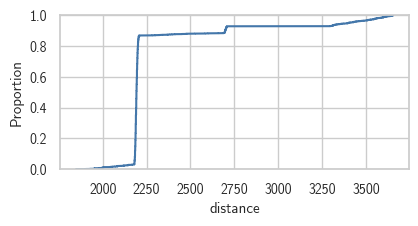

In [293]:
print(max(results_df["distance"]))
print(min(results_df["distance"]))
print(results_df["distance"].mean())
print(results_df["distance"].std())
print(results_df["distance"].median())

sns.ecdfplot(data=results_df, x='distance')

In [302]:
results_df[(results_df["cache_hit"] == "True") & (results_df["time"] > 120) & (results_df["time"] < 1320)]["time_ms"].describe()

count    3926.000000
mean       21.578392
std        10.558411
min         9.414000
25%        14.387250
50%        19.403000
75%        24.124500
max       129.349000
Name: time_ms, dtype: float64

In [303]:
results_df[(results_df["cache_hit"] == "False") & (results_df["time"] > 120) & (results_df["time"] < 1320)]["time_ms"].describe()

count    7327.000000
mean       46.442499
std        18.979618
min        18.337000
25%        33.349500
50%        41.765000
75%        53.808000
max       131.646000
Name: time_ms, dtype: float64

In [304]:
3926.000000/ (3926.0000000 + 7327.000000)

0.34888474184661866

In [305]:
num_sats[(num_sats["time"] > 120) & (num_sats["time"] < 1320)]["deployed_sats"].describe()

count    119999.000000
mean          5.270494
std           1.547164
min           2.000000
25%           4.000000
50%           6.000000
75%           6.000000
max           8.000000
Name: deployed_sats, dtype: float64